In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams['font.sans-serif'] = ['Microsoft YaHei']

# 准备数据

In [2]:
x0 = np.linspace(-2, 2, 1000)
y0 = 2 * np.sin(x0)
y0 += 0.32 * np.random.randn(y0.shape[0]) # 加噪声

给x和y加一维

In [3]:
x = x0[:, np.newaxis]
y = y0[:, np.newaxis]
x.shape

(1000, 1)

# 线性回归损失作为基准（baseline）

In [4]:
def mse(yl, y0):
    return ((yl - y0)**2).sum()/yl.shape[0]

In [5]:
b2 = float((len(y0)*(x0*y0).sum(0) - y.sum(0)*x0.sum(0)) /
           (len(x0)*(x0**2).sum(0) - (x.sum(0)**2)))
b1 = float(y0.mean() - b2 * x0.mean())
print('回归方程为: y = {:.2f} + {:.2f} * x'.format(b1, b2))
# 数据是标准化的，因此截距项为0

回归方程为: y = -0.02 + 1.31 * x


In [6]:
yl = []
for i in x0:
    yl.append(b1 + b2 * i)
yl = np.array(yl)

In [7]:
baseline = mse(yl, y0) # type: ignore
print('线性回归平均损失:{:.4f}'.format(baseline))

线性回归平均损失:0.2045


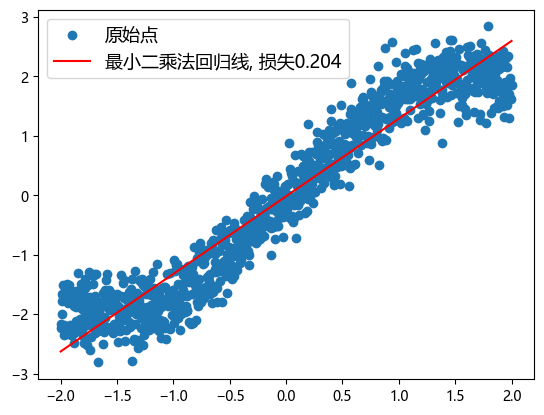

In [8]:
plt.scatter(x0, y0, label='原始点')
plt.plot(x, yl, 'r', label='最小二乘法回归线, 损失{:.3f}'.format(baseline))
plt.legend(fontsize='13')

# Tensorflow/keras神经网络框架

In [9]:
import tensorflow as tf
from tensorflow import keras

In [10]:
# type: ignore
model_tf = keras.models.Sequential([ 
    keras.layers.Dense(5, input_shape=[1,], activation='sigmoid'),
    keras.layers.Dense(1),
])

In [11]:
model_tf.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 5)                 10        
                                                                 
 dense_1 (Dense)             (None, 1)                 6         
                                                                 
Total params: 16
Trainable params: 16
Non-trainable params: 0
_________________________________________________________________


In [12]:
model_tf.compile(loss='mse', optimizer=keras.optimizers.SGD(0.01))

In [13]:
history = model_tf.fit(x, y, epochs=50, validation_split=0.3)

Epoch 1/50
22/22 [==============================] - 1s 8ms/step - loss: 1.4838 - val_loss: 6.2583
Epoch 2/50
22/22 [==============================] - 0s 4ms/step - loss: 1.3168 - val_loss: 6.3711
Epoch 3/50
22/22 [==============================] - 0s 4ms/step - loss: 1.2212 - val_loss: 6.0765
Epoch 4/50
22/22 [==============================] - 0s 4ms/step - loss: 1.1385 - val_loss: 5.6717
Epoch 5/50
22/22 [==============================] - 0s 4ms/step - loss: 1.0598 - val_loss: 5.2560
Epoch 6/50
22/22 [==============================] - 0s 4ms/step - loss: 0.9835 - val_loss: 4.8968
Epoch 7/50
22/22 [==============================] - 0s 4ms/step - loss: 0.9097 - val_loss: 4.4423
Epoch 8/50
22/22 [==============================] - 0s 4ms/step - loss: 0.8386 - val_loss: 4.0308
Epoch 9/50
22/22 [==============================] - 0s 4ms/step - loss: 0.7703 - val_loss: 3.6713
Epoch 10/50
22/22 [==============================] - 0s 4ms/step - loss: 0.7054 - val_loss: 3.3194
Epoch 11/50
22/22 [

In [14]:
y_tf = model_tf.predict(x)

32/32 [==============================] - 0s 2ms/step


In [15]:
keras_mse = mse(y_tf, y)

<Axes: >

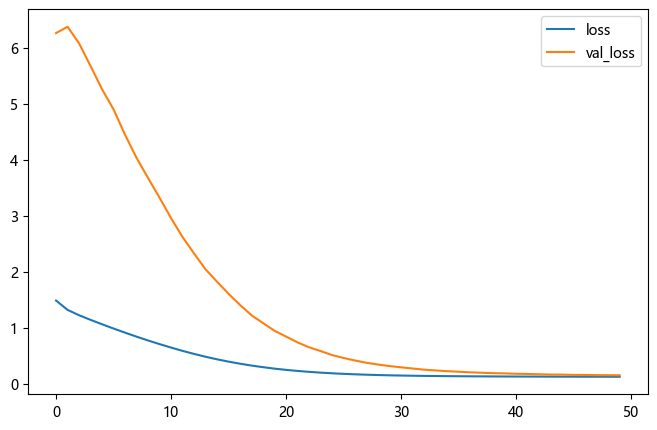

In [16]:
pd.DataFrame(history.history).plot(figsize=(8, 5))

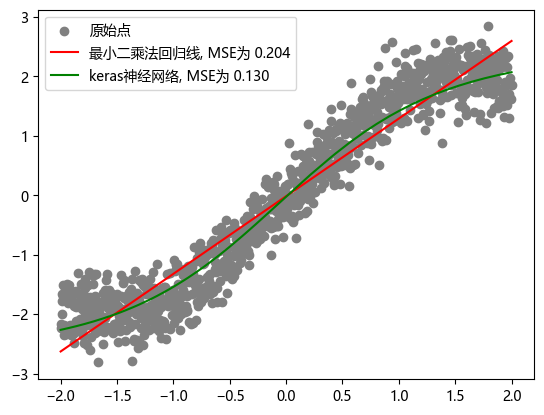

In [17]:
plt.scatter(x0, y0, c='gray', label='原始点')
plt.plot(x0, yl, 'r', label='最小二乘法回归线, MSE为 {:.3f}'.format(baseline))
plt.plot(x0, y_tf, 'green', label='keras神经网络, MSE为 {:.3f}'.format(keras_mse))
plt.legend(fontsize='10')

# 手搓神经网络框架

In [18]:
class BP():
    def __init__(self) -> None:
        pass

    def activate(self, t, activator='sigmoid'):
        '''
        激活函数， sigmoid 或 relu
        '''
        if activator == 'sigmoid':
            return 1/(1+np.e**(-t))
        if activator == 'relu':
            if t > 0:
                return t
            else:
                return 0

    def input_forward_hidden(self, x, activator='sigmoid'): # 输入层到隐藏层
        ''' 
        y11 = w1x1 + b1 \\
        输出大小 (5, 1) -> (神经元数量, x数量) \\
        输出 y12 (y11在反向传播用不到)
        '''
        x = x[:, np.newaxis]
        y11 = self.w1 @ x + self.b1 # 叉乘**
        y12 = self.activate(y11, activator)
        return y12

    def hidden_forward_output(self, y12, activator='sigmoid'):  # 隐藏层到输出层
        ''' 
        y21 = y12 * w2 + b2 \\
        大小 (1, 1) -> (神经元数量, y数量) \\
        输出 y21, y21(最终输出)
        '''
        y21 = self.w2 @ y12 + self.b2 # 叉乘**
        return y21

    def metrics(self, y_p, y_t, loss='mse') -> float: # type: ignore
        '''
        计算误差
        '''
        if loss == 'mse':  # 均方差
            return (((y_p - y_t)**2).sum()/2)

    # 下面是四个参数的反向传播更新，公式是手推链式求导直接写的**
    def update_w2(self, yt, y21, y12, lr=0.02):
        '''
        更新输出层权重,先是输出层w2
        '''
        delta_w2 = (y21 - yt).sum() * y12.T
        return self.w2 - lr * delta_w2

    def update_b2(self, yt, y21, lr=0.02):
        delta_b2 = (y21 - yt).sum()
        return self.b2 - lr * delta_b2
    
    def update_w1(self, yt, y21, y12, x, lr=0.02):
        delta_w1 = (y21 - yt).sum() * self.w2.T * y12 * (1 - y12) * x.T
        return self.w1 - lr * delta_w1
    
    def update_b1(self, yt, y21, y12, lr=0.02):
        delta_b1 = (y21 - yt).sum() * self.w2.T * y12 * (1 - y12)
        return self.b1 - lr * delta_b1
    
    def fit(self, x, y):
        self.w1 = np.random.randn(5, 1) # (本层神经元数量, 一次输入一个)，实际上可以用batch一次多个**
        self.b1 = np.random.randn(5, 1) # 本层神经元数量, 一维神经网络就一层**
        self.w2 = np.random.randn(1, self.w1.shape[0]) # 本层神经元数量，实例输入量(上一层神经元数量)**
        self.b2 = np.random.randn(1, 1) # 本层神经元数量, 一维神经网络就一层**
        self.y = y
        self.x = x
        self.mse = 0
        
        # 统计损失
        self.list_mse = []
        
    def train(self, epochs, lr=0.02, activator='sigmoid', loss_type='mse', target_error=0.00):
        for _ in range(epochs): 
            for xs, yt in zip(self.x, self.y): # x_sample, y_true(label)
                y12 = self.input_forward_hidden(xs, activator)
                y21 = self.hidden_forward_output(y12, activator)
                self.w2 = self.update_w2(yt, y21, y12, lr)
                self.b2 = self.update_b2(yt, y21, lr)
                self.w1 = self.update_w1(yt, y21, y12, xs, lr)
                self.b1 = self.update_b1(yt, y21, y12, lr)
                self.mse = self.metrics(y21, yt, loss_type) # type: ignore
            self.list_mse.append(self.mse)
                
            if self.mse <= target_error:
                print('✅ 共{:d}轮, 达到目标损失, 最终损失E={:.5f}'.format(_+1, self.mse))
                break
            
            if _ > 15 and np.mean(self.list_mse[-15: -1]) < self.list_mse[-1]:
                print('✅ 共{:d}轮, 损失反向增大，自动停止, 最终损失E={:.5f}'.format(_+1, self.mse))
                break
            
            elif _ == epochs - 1 and self.mse > target_error:
                print('❌ 共{:d}轮, 最终损失E={:.5f}, 未达到目标损失 {:.5f}'.format(_+1, self.mse, target_error))
                break
            
                
    def fit_transform(self, x, y, epochs:int, lr=0.01, activator='sigmoid', loss_type='mse', target_error=0.00):
        '''
        epochs: 最大轮次, 每一轮次过一次全部数据 \\
        lr: 学习率, 默认0.01 \\
        activator: 'sigmoid' 或 'relu'(尚未配适反向传播, 勿用) \\
        loss_type: 损失类型, 目前仅有 "mse"
        '''
        self.fit(x, y)
        self.train(epochs, lr, activator, loss_type, target_error)
        
    def predict(self, new_x):
        y_lst = []
        for i in new_x:
            y0 = self.input_forward_hidden(i)
            y1 = self.hidden_forward_output(y0)
            y_lst.append(y1)
        y_lst = np.array(y_lst)
        y_lst = y_lst.reshape(y_lst.shape[0])
        return y_lst
        

In [19]:
model = BP()

In [20]:
model.fit_transform(x, y, 100, lr=0.001, )

✅ 共18轮, 损失反向增大，自动停止, 最终损失E=0.02006


# 损失情况

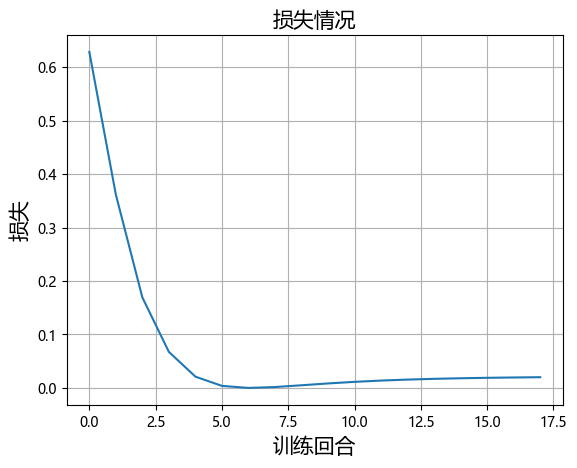

In [21]:
plt.title('损失情况', fontsize=15)
plt.ylabel('损失', fontsize=15)
plt.xlabel('训练回合', fontsize=15)
plt.grid()
plt.plot(model.list_mse, label='神经网络')

In [22]:
yp = model.predict(x)

In [23]:
bp_mse = mse(yp, y0)

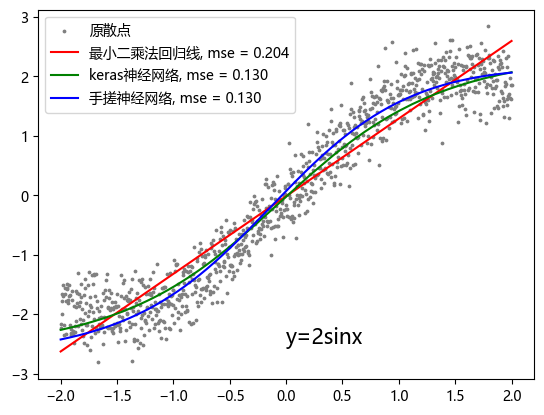

In [24]:
plt.text(0, -2.5, 'y=2sinx', fontsize=15)
plt.scatter(x, y, s=3, c='gray', label='原散点')
plt.plot(x0, yl, 'r', label='最小二乘法回归线, mse = {:.3f}'.format(baseline))
plt.plot(x0, y_tf, 'green', label='keras神经网络, mse = {:.3f}'.format(keras_mse))
plt.plot(x, yp, c='b', label='手搓神经网络, mse = {:.3f}'.format(bp_mse))
plt.legend(fontsize=10)